# 3D synthetic model & observations
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units, constants
from scipy.interpolate    import griddata

from pomme.utils       import convert_angular_to_spatial
from pomme.plot        import plot_cube_2D
from pomme.object      import AstroObject
from pomme.observation import DataCube

from pomme.model       import TensorModel, SphericallySymmetric
from pomme.utils       import print_var, interpolate
from pomme.lines       import Line
from pomme.loss        import Loss, fourier_loss_1D, fourier_loss_1D
from pomme.haar        import Haar

In [2]:
# File name
input_file = "/STER/frederikd/Magritte-examples/Phantom_3D/model_Phantom_3D.ascii"

# Read the Phantom ascii file
(x,y,z, h, rho, v_x,v_y,v_z, u) = np.loadtxt(input_file, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

# Constants that can be read from ascii file
velocity_cte = 2.9784608e+06
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

r_grav_1 = np.array([x[-1], y[-1], z[-1]]) * constants.au.si.value
r_grav_2 = np.array([x[-2], y[-2], z[-2]]) * constants.au.si.value

keep = np.logical_and(h>0.0, rho>0.0)

# Exclude unphysical points and points with zero abundance
x   = x  [keep]
y   = y  [keep]
z   = z  [keep]
v_x = v_x[keep]
v_y = v_y[keep]
v_z = v_z[keep]
u   = u  [keep]
rho = rho[keep]

# Extract the number of points
npoints = len(x)

# Convert rho (total density) to abundances
nH2 = rho * density_cte * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convert to m/s
v_x *= velocity_cte * 0.01
v_y *= velocity_cte * 0.01
v_z *= velocity_cte * 0.01

position = np.array((x, y, z)).transpose()

# Convert units
position *= constants.au.si.value   # Convert au to m

# Derive temperature from internal energy (assuming adiabatic heating/cooling)
gamma = 1.2
mu    = 2.381
tmp   = mu * (gamma-1.0) * u * energy_cte * 1.00784 * (units.erg/units.g * constants.u/constants.k_B).to(units.K).value

# Cut-off temperatures below 2.725 K
tmp[tmp<2.725] = 2.725

# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=9)

# nCO_dat = haar.map_data(nCO, interpolate=True)[-1][8:56,8:56,8:56]
# tmp_dat = haar.map_data(tmp, interpolate=True)[-1][8:56,8:56,8:56]
# v_x_dat = haar.map_data(v_x, interpolate=True)[-1][8:56,8:56,8:56]
# v_y_dat = haar.map_data(v_y, interpolate=True)[-1][8:56,8:56,8:56]
# v_z_dat = haar.map_data(v_z, interpolate=True)[-1][8:56,8:56,8:56]

# nCO_dat = haar.map_data(nCO, interpolate=True)[-1][17:111,17:111,17:111]
# tmp_dat = haar.map_data(tmp, interpolate=True)[-1][17:111,17:111,17:111]
# v_x_dat = haar.map_data(v_x, interpolate=True)[-1][17:111,17:111,17:111]
# v_y_dat = haar.map_data(v_y, interpolate=True)[-1][17:111,17:111,17:111]
# v_z_dat = haar.map_data(v_z, interpolate=True)[-1][17:111,17:111,17:111]

nCO_dat = haar.map_data(nCO, interpolate=True)[-1][32:224,32:224,32:224]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][32:224,32:224,32:224]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][32:224,32:224,32:224]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][32:224,32:224,32:224]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][32:224,32:224,32:224]

assert tmp_dat.shape == nCO_dat.shape
assert tmp_dat.shape == v_z_dat.shape

model_test = TensorModel(shape=nCO_dat.shape, sizes=haar.xyz_L)
model_test['log_CO'         ]  = np.log(nCO_dat).astype(np.float64)
model_test['log_temperature']  = np.log(tmp_dat).astype(np.float64)
model_test['velocity_x']       =        v_x_dat .astype(np.float64)
model_test['velocity_y']       =        v_y_dat .astype(np.float64)
model_test['velocity_z']       =        v_z_dat .astype(np.float64)

In [6]:
np.abs(position)

304.09808663543214

In [11]:
np.max(position, axis=0) - np.min(position, axis=0) 

array([5.97036639e+13, 5.96943929e+13, 5.97370851e+13])

In [13]:
(1.0 * units.au).si

<Quantity 1.49597871e+11 m>

In [20]:
import torch
print_var('nCO', torch.from_numpy(nCO))

nCO +1.43e+06 +8.76e+09 +4.91e+12


In [16]:
np.max(nCO)

4911074390436.68

In [3]:
# reduce = lambda a: 0.25*(a[0::2,0::2,:] + a[1::2,0::2,:] + a[0::2,1::2,:] + a[1::2,1::2,:])

# nCO_dat = reduce(nCO_dat)
# tmp_dat = reduce(tmp_dat)
# v_x_dat = reduce(v_x_dat)
# v_y_dat = reduce(v_y_dat)
# v_z_dat = reduce(v_z_dat)

# nCO_dat = reduce(nCO_dat)
# tmp_dat = reduce(tmp_dat)
# v_x_dat = reduce(v_x_dat)
# v_y_dat = reduce(v_y_dat)
# v_z_dat = reduce(v_z_dat)

In [4]:
plot_cube_2D(np.log(nCO_dat))

interactive(children=(IntSlider(value=95, description='z', max=191), Output()), _dom_classes=('widget-interact…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [5]:
assert tmp_dat.shape == nCO_dat.shape
assert tmp_dat.shape == v_z_dat.shape

tm = TensorModel(shape=nCO_dat.shape, sizes=haar.xyz_L)
tm['log_CO'         ]  = np.log(nCO_dat)
tm['log_temperature']  = np.log(tmp_dat)
tm['velocity_z']       =        v_z_dat
tm['log_v_turbulence'] = np.log(np.array([trb]))

In [6]:
vel = np.array((v_x_dat.reshape(-1), v_y_dat.reshape(-1), v_z_dat.reshape(-1))).T
pos = np.moveaxis(tm.get_coords(), 0, -1).reshape(-1, 3)
nCO = nCO_dat          .reshape(-1)
tmp = tmp_dat          .reshape(-1)

# np.save("nCO", nCO_dat)
# np.save("tmp", tmp_dat)
# np.save("vel", vel_dat)
# np.save("pos", pos_dat)

# pos_dat = model.get_coords().T
# np.save("pos_cube", pos_dat)

In [7]:
pos_min = np.min(pos, axis=0)
pos_max = np.max(pos, axis=0)

bdy = []
for i in range(3):
    bdy += list(np.where(pos[:,i] == pos_max[i])[0])
    bdy += list(np.where(pos[:,i] == pos_min[i])[0]) 
bdy = sorted(set(bdy))

In [8]:
import magritte.core  as magritte
import magritte.setup as setup

In [9]:
# Magritte setup
modelFile = "magritte_model.hdf5"
lamdaFile = "data/co.txt"
dimension = 3
npoints   = pos.shape[0]
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 100

print("npoints:", npoints)

npoints: 7077888


In [9]:
mm = magritte.Model ()
mm.parameters.set_spherical_symmetry(False)
mm.parameters.set_model_name        (modelFile)
mm.parameters.set_dimension         (dimension)
mm.parameters.set_npoints           (npoints)
mm.parameters.set_nrays             (nrays)
mm.parameters.set_nspecs            (nspecs)
mm.parameters.set_nlspecs           (nlspecs)
mm.parameters.set_nquads            (nquads)

ones  = np.ones (npoints)
zeros = np.zeros(npoints)

mm.geometry.points.position.set(pos)
mm.geometry.points.velocity.set(vel/constants.c.si.value)

mm.chemistry.species.abundance = np.array((zeros, nCO, nCO, zeros, ones)).T
mm.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

mm.thermodynamics.temperature.gas  .set( tmp)
mm.thermodynamics.turbulence.vturb2.set((trb/magritte.CC)**2 * np.ones(npoints))

mm.parameters.set_nboundary(len(bdy))
mm.geometry.boundary.boundary2point.set(bdy)

direction = np.array([[0,0,+1], [0,0,-1]])         # Comment out to use all directions
mm.geometry.rays.direction.set(direction)          # Comment out to use all directions
mm.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

mm = setup.set_Delaunay_neighbor_lists (mm)
mm = setup.set_boundary_condition_zero (mm)
mm = setup.set_linedata_from_LAMDA_file(mm, lamdaFile, {'considered transitions': [0]})
mm = setup.set_quadrature              (mm)

mm.write()
mm.read ()

In [ ]:
mm.compute_spectral_discretisation ()
mm.compute_inverse_line_widths     ()
mm.compute_LTE_level_populations   ()

Computing spectral discretisation...
Computing inverse line widths...
Computing LTE level populations...


0

In [ ]:
fcen = mm.lines.lineProducingSpecies[0].linedata.frequency[0]
vpix = 750   # velocity pixel size [m/s]
dd   = vpix * (mm.parameters.nfreqs()-1)/2 / magritte.CC
fmin = fcen - fcen*dd
fmax = fcen + fcen*dd

mm.compute_spectral_discretisation (fmin, fmax, 100)
mm.compute_image_new(0, tm.shape[0], tm.shape[1])
# mm.compute_image(0)

Computing spectral discretisation...
Computing image new...


0

In [ ]:
model    = mm
image_nr = -1
zoom     = 1.0  
npix_x   = tm.shape[0]
npix_y   = tm.shape[1]
method   = 'nearest'

# Extract data of last image
imx = np.array(model.images[image_nr].ImX)
imy = np.array(model.images[image_nr].ImY)
imI = np.array(model.images[image_nr].I)

In [ ]:
# Extract the number of frequency bins
nfreqs = model.images[image_nr].nfreqs

# Set image boundaries
deltax = (np.max(imx) - np.min(imx))/zoom
midx = (np.max(imx) + np.min(imx))/2.0
deltay = (np.max(imy) - np.min(imy))/zoom
midy = (np.max(imy) + np.min(imy))/2.0

x_min, x_max = midx - deltax/2.0, midx + deltax/2.0
y_min, y_max = midy - deltay/2.0, midy + deltay/2.0

# Create image grid values
xs = np.linspace(x_min, x_max, npix_x)
ys = np.linspace(y_min, y_max, npix_y)

# Extract the spectral / velocity data
freqs = np.array(model.images[image_nr].freqs)
f_ij  = np.mean(freqs)
# velos = (freqs - f_ij) / f_ij * constants.c.to(v_unit).value

# Interpolate the scattered data to an image (regular grid)
Is = np.zeros((nfreqs))
zs = np.zeros((nfreqs, npix_x, npix_y))
for f in range(nfreqs):
    # Nearest neighbor interpolate scattered image data
    zs[f] = griddata(
        (imx, imy),
        imI[:,f],
        (xs[None,:], ys[:,None]),
        method=method,
        fill_value = 0.0 #for non-nearest neighbor interpolation, otherwise the ceil/floor functions will complain
    )
    Is[f] = np.sum(zs[f])
Is = Is / np.max(Is)

# Put zero/negative values to the smallest positive value
zs[zs<=0.0] = np.min(zs[zs>0.0])
# Put nan values to smallest positive value
zs[np.isnan(zs)] = np.min(zs[zs>0.0])

In [ ]:
plot_cube_2D(np.log(zs[:,1:-1,1:-1].T))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [10]:
import torch
import torch.nn as nn

from torch.optim import Adam

In [11]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [13]:
line = Line('CO', 0)

You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol


In [14]:
from astropy import constants

CC  = constants.c  .si.value   # Speed of light       [m/s]

def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    Doppler shifts frequencies given the velocity along the line of sight.
    """
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / CC)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs

In [15]:
from time import time

def forward(model, freqs):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    # t =- time()
    nCO    = torch.exp(model['log_CO'])         
    tmp    = torch.exp(model['log_temperature'])
    vel    =           model['velocity_z']
    v_turb = torch.exp(model['log_v_turbulence'])
    # t += time()
    # print("init       ", t)

    # t =- time()
    frequencies = get_doppler_shifted_frequencies(vel, freqs)
    # t += time()
    # print("Doppler    ", t)
    
    # Compute the LTE line emissivity and opacity, and the line profile
    # t =- time()
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    # t += time()
    # print("eta, chi    ", t)
    
    # Create an image of the line
    # t =- time()
    img = model.create_image(eta, chi, axis=2)
    # t += time()
    # print("create image", t)
    
    # Convolve with beam
    # img = convolve_with_beam(img)
    
    # Resolved out flux
    # img = resolved_out_flux(img)
    
    return img

In [16]:
N_freqs = 100
v_pixel = 750.0

fcen = line.frequency
vpix = 750   # velocity pixel size [m/s]
dd   = vpix * (N_freqs-1)/2 / constants.c.si.value
fmin = fcen - fcen*dd
fmax = fcen + fcen*dd

# dd    = (N_freqs-1)/2 * v_pixel/constants.c.si.value
# fmin  = line.frequency - line.frequency*dd
# fmax  = line.frequency + line.frequency*dd
freqs = torch.linspace(fmin, fmax, N_freqs, dtype=torch.float64)

In [17]:
with torch.no_grad():
    img_p = forward(tm, freqs)

In [18]:
# img_m = zs[:,1:-1,1:-1].T
img_m = zs.T

NameError: name 'zs' is not defined

In [19]:
plot_cube_2D(np.log(np.clip(img_p, 1.0e-30, np.inf)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [ ]:
plot_cube_2D(np.log(np.clip(img_m[1:-1,1:-1,:], 1.0e-30, np.inf)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

### WARNING: Still assumes inverted Doppler shift in Magritte!

In [20]:
from ipywidgets    import interact

def plot_spectrum(cube_m, cube_p):
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.plot(freqs.numpy()[::-1], cube_m[i,j,:])
        plt.plot(freqs.numpy()[::+1], cube_p[i,j,:])
        plt.ylim((1.0e-30, 1.0e+1))
        plt.yscale('log')
        plt.axvline(line.frequency, c='k')

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, cube_m.shape[0]-1),
                    j=(0, cube_m.shape[1]-1) )

plot_spectrum(img_m, img_p)

NameError: name 'img_m' is not defined

In [21]:
obs = img_p
fqs = freqs

def half_resolution(x):
    return 0.25*(x[0::2,0::2,:] + x[0::2,1::2,:] + x[1::2,0::2,:] + x[1::2,1::2,:])

# Create a list of hiearchically reduced observations
# obs_list = [obs]
# while obs.shape[0]/2 >= 24:
#     obs = half_resolution(obs)
#     obs_list.append(obs)
# 
# for i, obs in enumerate(obs_list):
#     print(f'obs_list[{i}].shape =', list(obs.shape))

In [22]:
plot_cube_2D(np.log(np.clip(obs, 1.0e-30, np.inf)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [25]:
shape = (obs.shape[0], obs.shape[1], 192)
sizes = haar.xyz_L

In [26]:
shape

(192, 192, 192)

In [27]:
sizes

array([5.97037805e+13, 5.96945095e+13, 5.97372017e+13])

In [28]:
model = TensorModel(
    sizes  = sizes,
    shape  = shape,
)

origin_pos    = 0.5 * (r_grav_1 + r_grav_2)
origin_ind    = model.shape * (origin_pos - haar.xyz_min) / haar.xyz_L
r_x, r_y, r_z = model.get_radial_direction(origin=origin_ind)

model['log_M_1'         ] = np.array([np.log(constants.M_sun.si.value)])
model['log_M_2'         ] = np.array([np.log(constants.M_sun.si.value)])
model['log_CO'          ] = np.log(1.0e+9) * np.ones(model.shape)
model['log_temperature' ] = np.log(5.0e+2) * np.ones(model.shape)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)
# model['velocity_x'      ] =        0.0     * np.ones(model.shape)
# model['velocity_y'      ] =        0.0     * np.ones(model.shape)
# model['velocity_z'      ] =        0.0     * np.ones(model.shape)
model['velocity_x'      ] = 1.0e+1 * r_x
model['velocity_y'      ] = 1.0e+1 * r_y
model['velocity_z'      ] = 1.0e+1 * r_z

# loss = Loss(['reg', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])
# loss = Loss(['rep', 'reg', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])
loss = Loss(['rep', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])

# for i in range(model.shape[0]):
#     for j in range(model.shape[1]):
#         model['velocity_x'][i,j,:] = torch.linspace(-1.0e+1, +1.0e+1, model.shape[2])
#         model['velocity_y'][i,j,:] = torch.linspace(-1.0e+1, +1.0e+1, model.shape[2])
#         model['velocity_z'][i,j,:] = torch.linspace(-1.0e+1, +1.0e+1, model.shape[2])

model.free_all()
model.fix('log_v_turbulence')

model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_M_1                    Free          False    +6.976e+01     +6.976e+01     +6.976e+01
  log_M_2                    Free          False    +6.976e+01     +6.976e+01     +6.976e+01
  log_CO                     Free          True     +2.072e+01     +2.072e+01     +2.072e+01
  log_temperature            Free          True     +6.215e+00     +6.215e+00     +6.215e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  velocity_x                 Free          True     -1.000e+01     -2.254e-01     +1.000e+01
  velocity_y                 Free          True     -1.000e+01     -4.545e-02     +1.000e+01
  velocity_z                 Free          True     -1.000e+01     -3.869e-02     +1.000e+01
sizes: [5.97037805e+13 5.96945095e+13 5.97372017e+13]
shape: (192, 192, 192)


In [29]:
def velocity_cube_2D(coords, vx, vy, vz):
    """
    Plot a slice along the third axis through a 3D cube.
    """
    v = torch.sqrt(vx**2 + vy**2 + vz**2)

    vmin = v.min().item()
    vmax = v.max().item()

    def plot(z):
        plt.figure(dpi=150)
        # plt.imshow(v[:,:,z].T.data, vmin=vmin, vmax=vmax, origin='lower')
        plt.quiver(
            coords[0,:,:,z],
            coords[1,:,:,z],
            (vx/v)[:,:,z].data,
            (vy/v)[:,:,z].data,
            # color = 'white',
            pivot='mid'
        )
    return interact(plot, z=(0,v.shape[2]-1))

velocity_cube_2D(
    coords = model.get_coords(),
    vx     = model['velocity_x'],
    vy     = model['velocity_y'],
    vz     = model['velocity_z']
)

interactive(children=(IntSlider(value=95, description='z', max=191), Output()), _dom_classes=('widget-interact…

<function __main__.velocity_cube_2D.<locals>.plot(z)>

In [30]:
def forward(model, freqs):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    nCO    = torch.exp(model['log_CO'])         
    tmp    = torch.exp(model['log_temperature'])
    vel    =  3.0e+3 * model['velocity_z']
    v_turb = torch.exp(model['log_v_turbulence'])

    frequencies = get_doppler_shifted_frequencies(vel, freqs)
    
    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    
    # Create an image of the line
    img = model.create_image(eta, chi, axis=2)
    
    return img

In [31]:
# def fourier_loss_3D(arr):
    
#     arr_min = arr.min()
#     arr_max = arr.max()
    
#     if arr_min != arr_max:
#         arr = (arr - arr_min) * (1.0 / (arr_max - arr_min))
    
#     fft = torch.abs(torch.fft.fftn(arr))
#     # fft[(0,)*fft.dim()] = 0.0
#     fft = fft / fft[(0,)*fft.dim()]
    
#     wgt = np.indices(fft.shape)
#     wgt = (wgt.T - 0.5*np.array(fft.shape)).T
#     wgt = np.linalg.norm(wgt, axis=0)
    
#     wgt = torch.from_numpy(wgt)

#     loss = torch.mean((torch.fft.fftshift(fft)*wgt)**2)

#     return loss

def fourier_loss_3D(arr):
    
    fft = torch.abs(torch.fft.fftn(arr))
    
    wgt = np.indices(fft.shape)
    wgt = (wgt.T - 0.5*np.array(fft.shape)).T
    wgt = np.linalg.norm(wgt, axis=0)
    
    wgt = torch.from_numpy(wgt)

    loss = torch.mean((torch.fft.fftshift(fft)*wgt)**2)
    
    return loss

In [32]:
gamma  = 1.2
mu     = 2.381
factor = 2.0 * constants.R.si.value / (mu * (gamma - 1.0))


def lagrangian(model):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    nCO    = torch.exp(model['log_CO'])         
    tmp    = torch.exp(model['log_temperature'])
    vel    =  3.0e+3 * model['velocity_z']
    v_turb = torch.exp(model['log_v_turbulence'])

    return nCO * (vel**2 - factor * tmp)

In [33]:
gamma = 1.2
mu    = 2.381 * constants.u.si.value

def steady_state_hydrodynamic_loss(model, f_x=0.0, f_y=0.0, f_z=0.0, heating_m_cooling=0.0):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """

    o_1 = model.shape * (r_grav_1 - haar.xyz_min) / haar.xyz_L
    o_2 = model.shape * (r_grav_2 - haar.xyz_min) / haar.xyz_L
    
    r_1 = model.get_coords(origin=o_1)
    r_2 = model.get_coords(origin=o_2)

    d_1 = torch.from_numpy(r_1 / np.linalg.norm(r_1, axis=0)**3)
    d_2 = torch.from_numpy(r_2 / np.linalg.norm(r_2, axis=0)**3)
    
    log_rho = model['log_CO']
    log_tmp = model['log_temperature'] 
    log_M_1 = model['log_M_1']
    log_M_2 = model['log_M_2']

    rho = torch.exp(log_rho)         
    tmp = torch.exp(log_tmp)
    M_1 = torch.exp(log_M_1)
    M_2 = torch.exp(log_M_2)
    
    v_x = 3.0e+3 * model['velocity_x']
    v_y = 3.0e+3 * model['velocity_y']
    v_z = 3.0e+3 * model['velocity_z']

    kBT_o_mu = (constants.k_B.si.value / mu) * tmp

    # Energy    
    eng = 0.5 * (v_x**2 + v_y**2 + v_z**2) + (gamma / (gamma - 1.0)) * kBT_o_mu

    # log rho + log T
    log_rho_p_log_tmp = log_rho + log_tmp
    
    f_x = -constants.G.si.value * (M_1 * d_1[0] + M_2 * d_2[0])
    f_y = -constants.G.si.value * (M_1 * d_1[1] + M_2 * d_2[1])
    f_x = -constants.G.si.value * (M_1 * d_1[2] + M_2 * d_2[2])

    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = model.diff_x(rho * v_x) + model.diff_y(rho * v_y) + model.diff_z(rho * v_z)

    # Momentum equation (steady state): v . grad(v) + grad(P) / rho = f
    loss_momx = v_x * model.diff_x(v_x) + v_y * model.diff_y(v_x) + v_z * model.diff_z(v_x) + kBT_o_mu * model.diff_x(log_rho_p_log_tmp) - f_x
    loss_momy = v_x * model.diff_x(v_y) + v_y * model.diff_y(v_y) + v_z * model.diff_z(v_y) + kBT_o_mu * model.diff_y(log_rho_p_log_tmp) - f_y
    loss_momz = v_x * model.diff_x(v_z) + v_y * model.diff_y(v_z) + v_z * model.diff_z(v_z) + kBT_o_mu * model.diff_z(log_rho_p_log_tmp) - f_z

    # Energy equation (steady state): div(u v) = 0
    loss_engy = rho * (model.diff_x(eng) * v_x + model.diff_y(eng) * v_y + model.diff_z(eng) * v_z) - heating_m_cooling

    # Compute the mean squared losses
    losses = torch.stack([
        ((loss_cont/     rho )**2).mean(),
        ((loss_momx/     v_x )**2).mean(),
        ((loss_momy/     v_y )**2).mean(),
        ((loss_momz/     v_z )**2).mean(),
        ((loss_engy/(rho*eng))**2).mean()
    ])

    # Return losses
    return losses

In [79]:
loss_cont, loss_momx, loss_momy, loss_momz, loss_engy = steady_state_hydrodynamic_loss(model_test)

KeyError: 'log_M_1'

In [ ]:
steady_state_hydrodynamic_loss(model_test)

KeyError: 'log_M_1'

In [34]:
print_var('square diff =', (obs-forward(model, freqs))**2)

square diff = +0.00e+00 +4.96e-34 +1.13e-31


In [35]:
print_var('Fourier loss =', model.apply_to_fields(fourier_loss_3D))

Fourier loss = +3.68e+10 +3.68e+10 +3.68e+10


In [36]:
print_var('Lagrangian loss =', lagrangian(model).mean())

Lagrangian loss = +3.00e+17 +3.00e+17 +3.00e+17


In [37]:
print_var('hydrodynamic loss =', steady_state_hydrodynamic_loss(model).mean())

hydrodynamic loss = +6.94e-16 +6.94e-16 +6.94e-16


In [38]:
w_rep = 1.0 / nn.functional.mse_loss(forward(model,freqs), obs).item()
w_reg = 1.0 / model.apply_to_fields(fourier_loss_3D).item()

L_con, L_mom_x, L_mom_y, L_mom_z, L_eng = steady_state_hydrodynamic_loss(model)

w_con = 1.0 / L_con.item()
w_mom = 1.0 / torch.stack([L_mom_x, L_mom_y, L_mom_z]).mean().item()
w_eng = 1.0 / L_eng.item()

In [39]:
def logg(x):
    return torch.log(1.0e-30 + x)

def fit(loss, model, obs, N_epochs=10, lr=1.0e-1, w_rep=1.0, w_reg=1.0, w_hyd=1.0, w_con=1.0, w_mom=1.0, w_eng=1.0):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model, freqs)
 
        # Compute the reproduction loss
        # loss['rep']              = w_rep * nn.functional.mse_loss(logg(img), logg(obs))
        # loss['rep']              =   logg( nn.functional.mse_loss(     img,       obs ))
        loss['rep']              = w_rep * nn.functional.mse_loss(     img,       obs )
        # loss_verification['ver'] =         nn.functional.mse_loss(     img,       obs ) 
        # Compute the regularisation loss
        # loss['reg'] = w_reg * model.apply_to_fields(fourier_loss_3D)
        # loss['hyd'] = w_hyd * steady_state_hydrodynamic_loss(model).mean()

        L_con, L_mom_x, L_mom_y, L_mom_z, L_eng = steady_state_hydrodynamic_loss(model)
    
        loss['hyd_con'] = w_con * L_con
        # loss['hyd_mom'] = w_mom * torch.stack([L_mom_x, L_mom_y, L_mom_z]).mean()
        loss['hyd_momx'] = w_mom * L_mom_x
        loss['hyd_momy'] = w_mom * L_mom_y
        loss['hyd_momz'] = w_mom * L_mom_z
        loss['hyd_eng'] = w_eng * L_eng

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

  0%|          | 0/5 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5/5 [03:51<00:00, 46.33s/it]


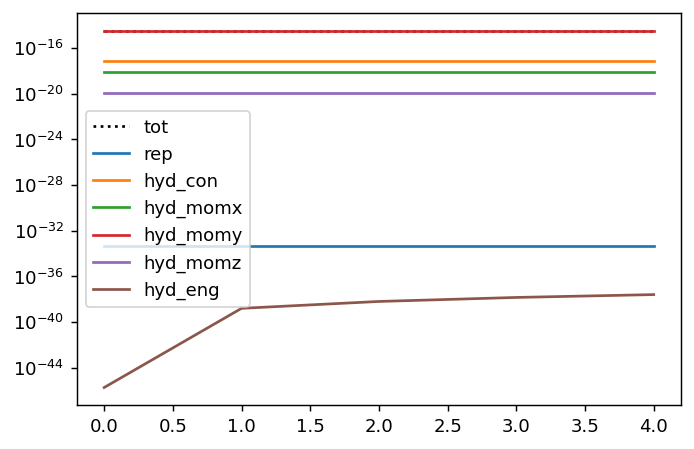

In [40]:
fit(loss, model, obs, N_epochs = 5, lr = 1.0e-1)
loss.plot()

In [41]:
w_rep = 1.0 /  loss['rep'     ].item()
# w_reg = 1.0 /  loss['reg'     ].item()
w_con = 1.0 /  loss['hyd_con' ].item()
w_mom = 3.0 / (loss['hyd_momx'] + loss['hyd_momy'] + loss['hyd_momz']).item()
w_eng = 1.0 /  loss['hyd_eng' ].item()

In [42]:
loss.__init__(keys=loss.loss.keys())

100%|██████████| 5/5 [03:38<00:00, 43.61s/it]


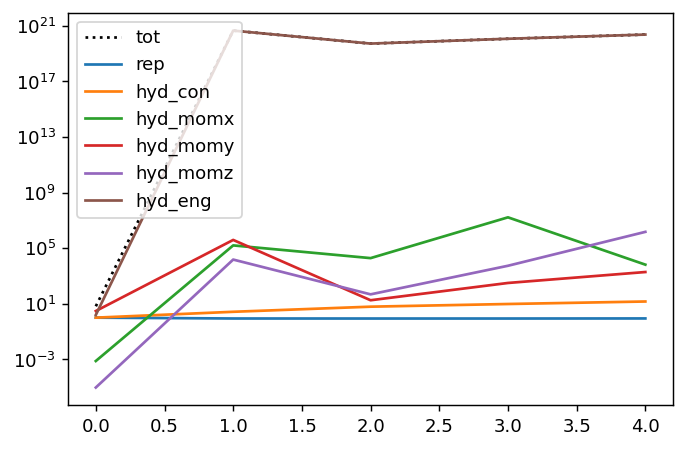

In [43]:
fit(loss, model, obs,
    N_epochs = 5,
    lr       = 1.0e-1,
    w_rep    = w_rep,
    w_reg    = w_reg,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

In [44]:
w_rep *= 1.0 /  loss['rep'     ].item()
# w_reg = 1.0 /  loss['reg'     ].item()
w_con *= 1.0 /  loss['hyd_con' ].item()
w_mom *= 3.0 / (loss['hyd_momx'] + loss['hyd_momy'] + loss['hyd_momz']).item()
w_eng *= 1.0 /  loss['hyd_eng' ].item()

In [45]:
loss.__init__(keys=loss.loss.keys())

100%|██████████| 50/50 [37:23<00:00, 44.88s/it]  


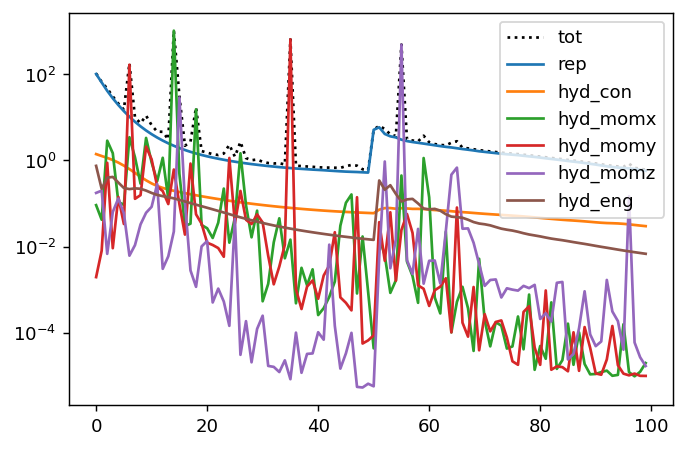

In [56]:
fit(loss, model, obs,
    N_epochs = 50,
    lr       = 1.0e-1,
    w_rep    = 1000*w_rep,
    w_reg    = w_reg,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

100%|██████████| 50/50 [37:22<00:00, 44.84s/it]  


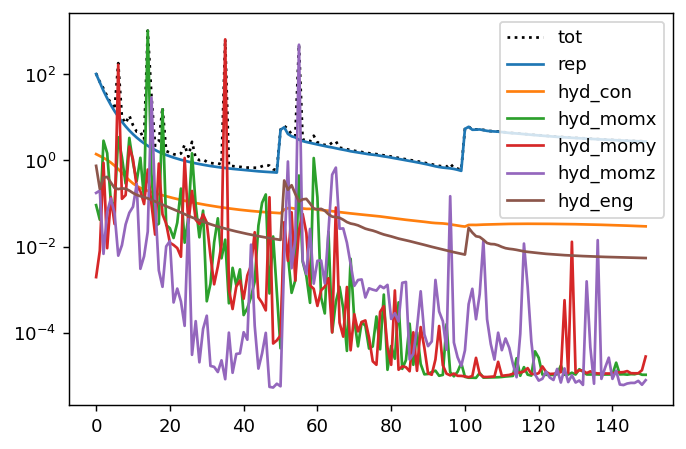

In [65]:
fit(loss, model, obs,
    N_epochs = 50,
    lr       = 2.0e-2,
    w_rep    = 10000*w_rep,
    w_reg    = w_reg,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

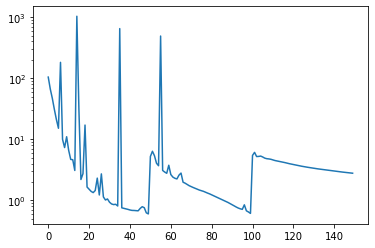

In [66]:
plt.plot(loss.losses_tot)
plt.yscale('log')

In [67]:
img = forward(model, freqs)



def plot_spectrum(cube_m, cube_p):
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function

    velos = (freqs / line.frequency - 1.0) * constants.c.si.value

    def plot(i,j):
        plt.figure(dpi=150)
        plt.title('Observations')
        plt.plot(velos, cube_m[i,j,:], label='img')
        plt.plot(velos, cube_p[i,j,:], label='obs')
        # plt.ylim((1.0e-30, 1.0e+1))
        # plt.yscale('log')
        # plt.axvline(line.frequency, c='k')
        plt.legend()

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, cube_m.shape[0]-1),
                    j=(0, cube_m.shape[1]-1) )

plot_spectrum(img.data, obs)

interactive(children=(IntSlider(value=95, description='i', max=191), IntSlider(value=95, description='j', max=…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [68]:
rs_m = np.linspace(pos_min[2], pos_max[2], nCO_dat.shape[2])
rs_p = np.linspace(pos_min[2], pos_max[2],   model.shape[2])

In [69]:
from ipywidgets    import interact

def plot_spectrum():
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.title('nCO')
        plt.plot(rs_m, nCO_dat[i,j,:], label='original')
        plt.plot(rs_p, torch.exp(model['log_CO'][j,i,:]).data, label='model')
        # plt.ylim((1.0e-30, 1.0e+1))
        plt.yscale('log')
        plt.legend()

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, model.shape[0]-1),
                    j=(0, model.shape[1]-1) )

plot_spectrum()

interactive(children=(IntSlider(value=95, description='i', max=191), IntSlider(value=95, description='j', max=…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [70]:
from ipywidgets    import interact

def plot_spectrum():
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.title('Temperature')
        plt.plot(rs_m, tmp_dat[i,j,:], label='original')
        plt.plot(rs_p, torch.exp(model['log_temperature'][j,i,:]).data, label='model')
        # plt.ylim((1.0e-30, 1.0e+1))
        # plt.yscale('log')
        plt.legend()

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, model.shape[0]-1),
                    j=(0, model.shape[1]-1) )

plot_spectrum()

interactive(children=(IntSlider(value=95, description='i', max=191), IntSlider(value=95, description='j', max=…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [72]:
from ipywidgets    import interact

def plot_spectrum():
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.title('Velocity z')
        plt.plot(rs_m, v_z_dat[i,j,:],                           label='original')
        plt.plot(rs_p, 3.0e+3 * model['velocity_z'][j,i,:].data, label='fit')
        # plt.ylim((1.0e-30, 1.0e+1))
        # plt.yscale('log')
        plt.legend()

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, model.shape[0]-1),
                    j=(0, model.shape[1]-1) )

plot_spectrum()

interactive(children=(IntSlider(value=95, description='i', max=191), IntSlider(value=95, description='j', max=…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [60]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=23, description='z', max=47), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [61]:
plot_cube_2D(model['log_temperature'])

interactive(children=(IntSlider(value=23, description='z', max=47), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [62]:
velocity_cube_2D(
    coords = model.get_coords(),
    vx     = model['velocity_x'],
    vy     = model['velocity_y'],
    vz     = model['velocity_z']
)

interactive(children=(IntSlider(value=23, description='z', max=47), Output()), _dom_classes=('widget-interact'…

<function __main__.velocity_cube_2D.<locals>.plot(z)>

In [63]:
fit(loss, model_3D, obs, N_epochs=1000, lr=1.0e-2, w_rep=1.0, w_reg=1.0e+3)

loss.plot()

NameError: name 'model_3D' is not defined

In [1]:
print_diff(model_3D_old, model_3D)

NameError: name 'print_diff' is not defined

In [32]:
plot_cube_2D(model_3D['log_CO'].data)

interactive(children=(IntSlider(value=127, description='z', max=255), Output()), _dom_classes=('widget-interac…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [33]:

def plot_spectrum(cube):
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.step(self.fs, self.img[:,i,j])
        plt.ylim((cube.min(), cube.max()))
        plt.xlabel(f'frequency [{self.f_unit}]')
        plt.ylabel(f'intensity [{self.I_unit}]')

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, cube.shape[0]-1),
                    j=(0, cube.shape[1]-1) )

In [34]:
img = forward(model_3D)

plot_cube_2D(img)

interactive(children=(IntSlider(value=16, description='z', max=33), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [35]:
# Define a plot function
def plot(i,j):
    plt.figure(dpi=150)
    plt.step(np.arange(img.shape[2]), img[i,j,:].data)
    plt.step(np.arange(obs.shape[2]), obs[i,j,:].data)
    plt.ylim((obs.min(), obs.max()))

# Return an interactive ipywidget
interact(plot,
         i=(0, img.shape[0]-1),
         j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='j', max=0), …

<function __main__.plot(i, j)>

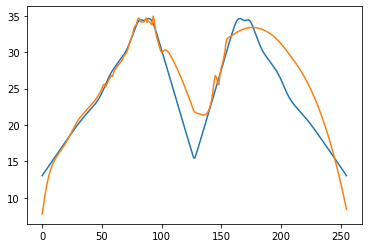

In [36]:
plt.plot(model_3D_old['log_CO'][0,0].data)
plt.plot(model_3D    ['log_CO'][0,0].data)

In [37]:
fourier_loss_3D(model_3D['log_CO'])

tensor(0.0061, dtype=torch.float64, grad_fn=<MeanBackward0>)

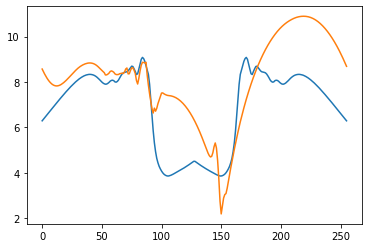

In [38]:
plt.plot(model_3D_old['log_temperature'][0,0].data)
plt.plot(model_3D    ['log_temperature'][0,0].data)

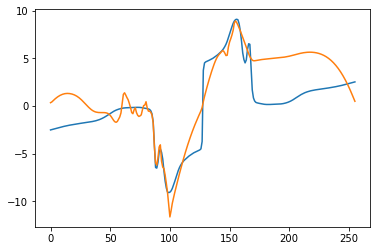

In [39]:
plt.plot(model_3D_old['velocity_z'][0,0].data)
plt.plot(model_3D    ['velocity_z'][0,0].data)

In [40]:
for obs in obs_list:
    print(obs.shape)

torch.Size([128, 128, 34])
torch.Size([64, 64, 34])
torch.Size([32, 32, 34])
torch.Size([16, 16, 34])
torch.Size([8, 8, 34])
torch.Size([4, 4, 34])
torch.Size([2, 2, 34])
torch.Size([1, 1, 34])


In [80]:
shape_z = 256

models = [model_3D]
losses = [loss]

for obs in obs_list:
    models.insert(0, TensorModel(
        sizes  = (size_x, size_y, size_z),
        shape  = (obs.shape[0], obs.shape[1], shape_z),
    ))
    losses.insert(0, Loss(['rep', 'reg']))

In [86]:
for model in models:
    print(model.shape)

(1, 1, 256)
(2, 2, 256)
(4, 4, 256)
(8, 8, 256)
(16, 16, 256)
(32, 32, 256)
(64, 64, 256)
(128, 128, 256)
(1, 1, 256)


In [113]:
model_3D.save(f"pomme_IK_Tau_0.hdf5")

In [114]:
shape_z = 64

models = [model_3D]
losses = [loss]

for obs in reversed(obs_list[:-1]):
    
    model = TensorModel(
        sizes  = (size_x, size_y, size_z),
        shape  = (obs.shape[0], obs.shape[1], shape_z),
    )
    loss = Loss(['rep', 'reg'])
                          
    print(obs.shape)
    model.interpolate_from_model(models[0])
    model.free_all()
    model.save(f"pomme_IK_Tau_{len(models)}.hdf5")

    fit(loss, model, obs, N_epochs=1000, lr=1.0e-2, w_rep=1.0, w_reg=1.0e+3)
                          
    models.insert(0, model)
    losses.insert(0, loss)

torch.Size([2, 2, 34])


100%|█████████████████████████████████| 1000/1000 [00:09<00:00, 102.82it/s]


torch.Size([4, 4, 34])


100%|██████████████████████████████████| 1000/1000 [00:10<00:00, 93.74it/s]


torch.Size([8, 8, 34])


100%|██████████████████████████████████| 1000/1000 [00:11<00:00, 87.07it/s]


torch.Size([16, 16, 34])


100%|██████████████████████████████████| 1000/1000 [00:20<00:00, 49.53it/s]


torch.Size([32, 32, 34])


100%|██████████████████████████████████| 1000/1000 [08:48<00:00,  1.89it/s]


torch.Size([128, 128, 34])


100%|██████████████████████████████████| 1000/1000 [39:46<00:00,  2.39s/it]


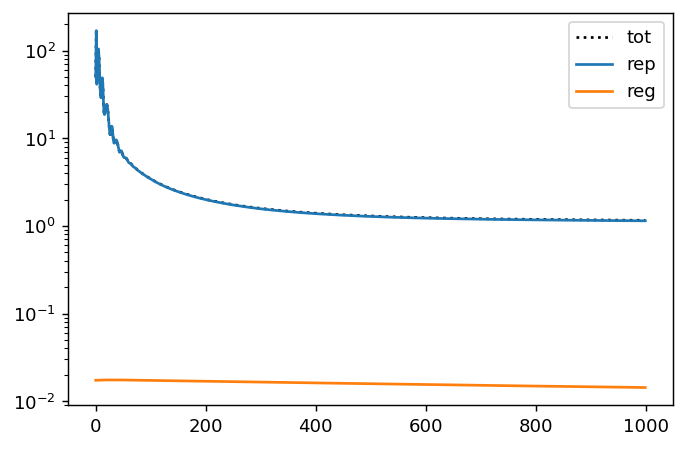

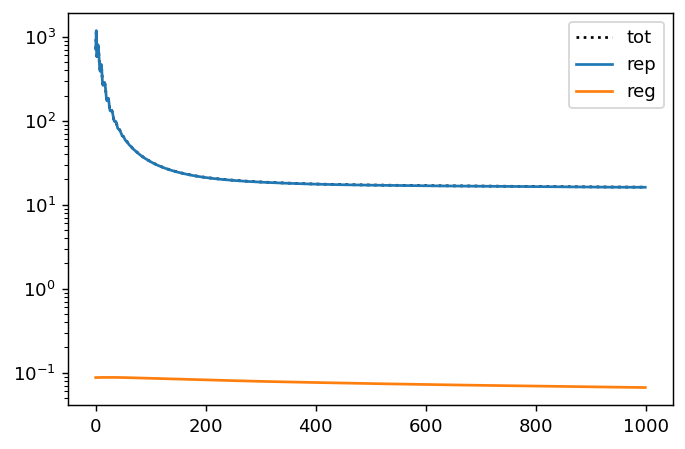

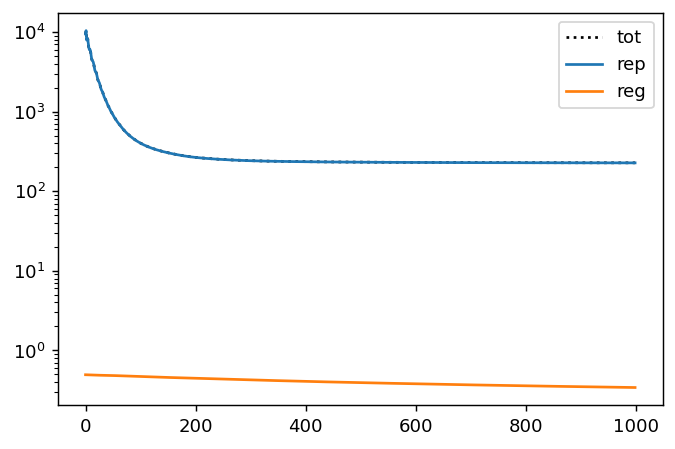

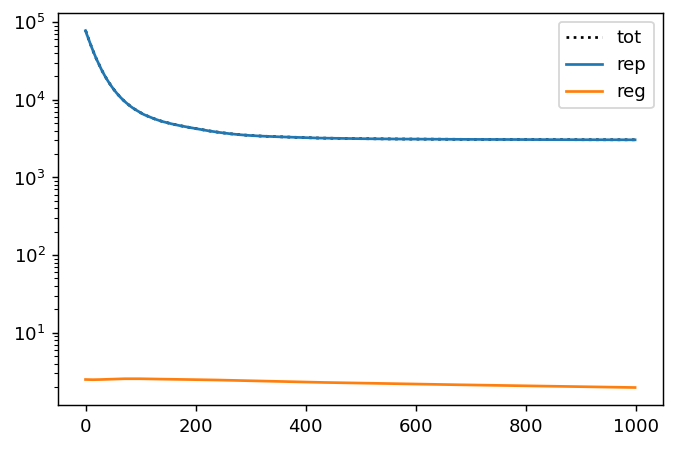

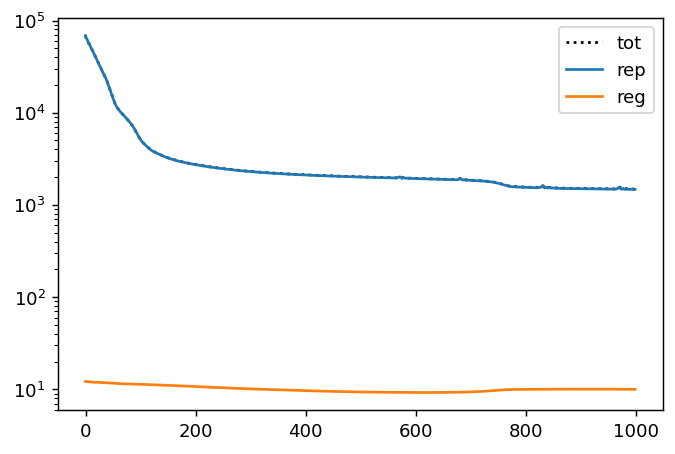

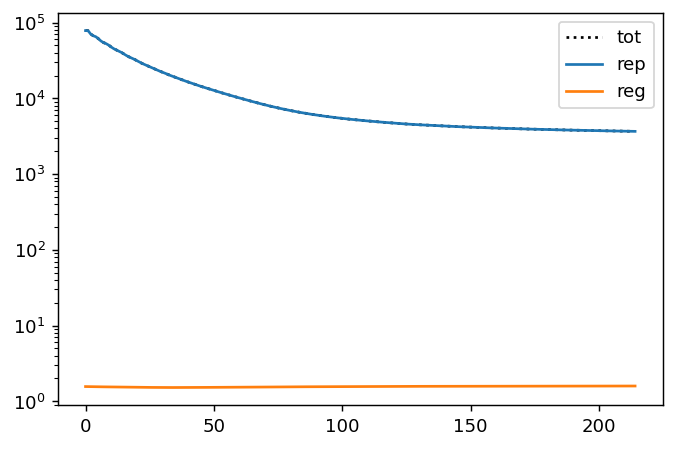

In [96]:
for loss in losses:
    loss.plot()

In [93]:
for m in models:
    print(m.shape)

(128, 128, 256)
(64, 64, 256)
(32, 32, 256)
(16, 16, 256)
(8, 8, 256)
(4, 4, 256)
(2, 2, 256)
(1, 1, 256)


In [53]:
for 

model_3D_2.interpolate_from_model(model_3D_)
model_3D_2.free_all()

loss = Loss(['rep', 'reg'])

In [59]:
model_3D_2.vars

{}

In [54]:
fit(model_3D_2, obs, N_epochs=1000, lr=1.0e-2, w_rep=1.0, w_reg=1.0e+3)

loss.plot()

ValueError: optimizer got an empty parameter list

In [103]:
n = -6

img = forward(models[n])
obs = obs_list[n]

# Define a plot function
def plot(i,j):
    plt.figure(dpi=150)
    plt.step(np.arange(img.shape[2]), img[i,j,:].data)
    plt.step(np.arange(obs.shape[2]), obs[i,j,:].data)
    plt.ylim((obs.min(), obs.max()))

# Return an interactive ipywidget
interact(plot,
         i=(0, img.shape[0]-1),
         j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=15, description='i', max=31), IntSlider(value=15, description='j', max=3…

<function __main__.plot(i, j)>

In [112]:
plot_cube_2D(models[-5]['log_CO'].T)

/tmp/ipykernel_3126811/1843582017.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plot_cube_2D(models[-5]['log_CO'].T)


interactive(children=(IntSlider(value=7, description='z', max=15), Output()), _dom_classes=('widget-interact',…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [106]:
import k3d

In [111]:
dat = models[-5]['log_CO'].data
# dat = obs_list[-5].data
dat = np.array(dat, dtype=np.float32)

plt_mip = k3d.mip(dat)

plot = k3d.plot()
plot += plt_mip
plot.display()

Output()